# Import Packages

In [1]:
import sys, os, pdb, glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy.table import Table, join, MaskedColumn
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.vizier import Vizier
import warnings
from astropy.logger import AstropyWarning
warnings.filterwarnings('ignore', category=AstropyWarning)

# Define Functions

In [2]:
def get_data(catalog, join_key='Name', join_type='inner'):

    """
    PURPOSE:    Get data from literature with Vizier

    INPUT:      catalog = ctalog name on Vizier (str)
                join_key = column header to join tables, if multiple (str; optional)
                join_type = way to join tables, if multiple (str; optional)

    OUTPUT:     t = data table (AstroPy Table)

    """

    ### GET FULL CATALOG (ALL COLUMNS, ALL ROWS)
    viz = Vizier(catalog=catalog, columns=['**'])
    viz.ROW_LIMIT = -1
    tv = viz.get_catalogs(catalog)

    ### IF MULTIPLE TABLES, JOIN THEN
    for i, val in enumerate(tv.keys()):
        if i == 0:
            t = tv[val]
        else:
            tt = tv[val]
            if join_key in tt.columns:
                t = join(t, tt, join_type=join_type, keys=join_key)

    return t

# Code

Load in Sigma Orionis data

In [3]:
T = get_data("J/AJ/153/240")

Add Separations (as calculated in calc_sep_ob.ipynb)

In [4]:
TS = Table.read('../output/sep_OB.txt', format='ascii.ipac')
T = join(T, TS, keys='__HHM2007_')

Only keep dust detections and sort table by increasing dust mass

Note: Used 2.9 because online table decimal places cutoff to make < 3.0

In [5]:
T = T[T['F1.33']/T['e_F1.33'] > 2.9]
T['Mdust'] = T['Mdust'] * (const.M_earth.cgs/const.M_sun.cgs).value
T['e_Mdust']  = np.sqrt( (T['e_Mdust'])**2 + (0.1*T['e_Mdust'])**2 )*(const.M_earth.cgs/const.M_sun.cgs).value
T.sort('Mdust')

Setup and create plot

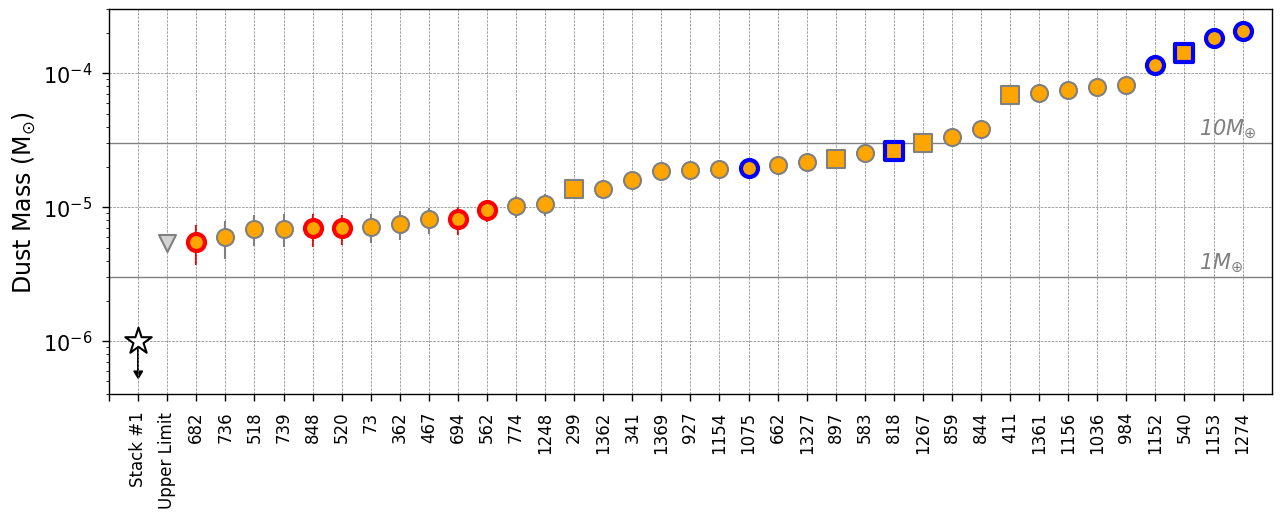

In [6]:
### SETUP PLOT
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
mpl.rc('xtick.major', size=5, pad=7, width=1)
mpl.rc('ytick.major', size=5, pad=7, width=1)
mpl.rc('axes', linewidth=1)
mpl.rc('lines', markersize=5)
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.grid(color='gray', linewidth=0.5, linestyle='dashed')
ax.set_yscale('log')
ax.set_xlim(-1, len(T))
ax.set_ylabel('Dust Mass (' + r'$\mathregular{M_{\odot}}$' + ')', fontsize=17)
ax.set_ylim(4e-7, 3e-4)

### SET X-TICKS AND LABEL
ax.xaxis.set_ticks(np.arange(-3, len(T), 1))
fig.canvas.draw()
labels = list(np.append([' ', 'Stack #1', 'Upper Limit'], np.array(T['__HHM2007_'])))
ax.set_xticklabels(labels, rotation='vertical', size=12)

### PLOT MARKERS
plt.axhline(y=3e-06, color='gray', linewidth=1.0)
ax.text(len(T) - 2.5, 3.5e-06, r'$\mathregular{1M_{\oplus}}$', fontsize=15, style='italic', color='gray')
plt.axhline(y=3e-05, color='gray', linewidth=1.0)
ax.text(len(T) - 2.5, 3.5e-05, r'$\mathregular{10M_{\oplus}}$', fontsize=15, style='italic', color='gray')

### GAS DETECTIONS & TRANSITION DISKS
GD = np.array(T[(T['F12CO']/T['e_F12CO'] >= 3.0) & (T['l_F12CO'] != '<')]['__HHM2007_'])
TD = np.array([540, 1268, 1267, 908, 897, 818, 540, 411, 299])

### PLOT UPPER LIMITS
ax.scatter(-2, 9.96e-07, marker='*', color='white', s=400, edgecolor='black', linewidth=1.5, zorder=999)
ax.arrow(-2, 9.96e-07, 0.0, -0.4 * 9.96e-07, head_width=0.3, head_length=9.96e-07 * 0.07, fc='black', ec='black', linewidth=1, zorder=1)
ax.scatter(-1, 5.4e-06, marker='v', color='lightgray', s=150, edgecolor='gray', linewidth=1.5, zorder=999)

### PLOT SOURCES
for i, val in enumerate(T['__HHM2007_']):

    ### SET PLOT SETTINGS BASED ON DISK TYPE & SEPARATION FROM SIGMA ORI
    ### ASSUMES DISTANCE TO ALL SIGMA ORI MEMBERS = 385 PC
    EdgeColor, LineWidth, FaceColor, MarkerShape = 'gray', 1.5, 'orange', 'o'
    if (val in GD):
        EdgeColor, LineWidth = 'blue', 3
    if (val in TD):
        MarkerShape = 's' 
    if (float(T['R_pc'][i]) <= 0.5):
        EdgeColor, LineWidth = 'red', 3

    ### PLOT SOURCE
    ax.scatter(i, T['Mdust'][i], marker=MarkerShape, facecolor=FaceColor, s=150, edgecolor=EdgeColor, linewidth=LineWidth, zorder=30)
    ax.errorbar(i, T['Mdust'][i], yerr=T['e_Mdust'][i], zorder=1, color=EdgeColor)

Save figure

In [7]:
fig.savefig('../output/figure_04.png', bbox_inches='tight', dpi=100)
plt.close('all')